In [1]:
import os
from datetime import datetime
import datetime as dt
from pyproj import Transformer
import matplotlib.pyplot as plt
import ee
import numpy as np
import pandas as pd
import fnmatch
from pyproj import Transformer
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyproj import Transformer
from scipy.stats import pearsonr
import sys

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

from dlm_functions import run_dlm
from helper_functions import calculate_bounds, to_df, get_api_response, wave_variance, plot_dlm_results, plot_gcc_comparison, plot_sweep_location, plot_sweep_extract, ews
from sweep_landscape_functions import sweep_locate, sweep_infil, sweep_extract, plot_landscape, plot_landscape_gif, synth_max_wp
from gee_import import Mod09gq_profiler, Mod13Q1_profiler

In [2]:
#import MODIS NDVI and Cosmos data for Glenwherry site
cosmos_df = pd.read_csv('example_data/glenwherry_example.csv')

In [3]:
#SWEEEP and DLM parameters
nseas = [1, 2]
rseas = nseas
wav = ('morlet', {'mu': 6})
vid = 2

l_period =  128 
u_period = 365.25 * 1.5
min_thresh = 0.1
fs = 1  
buff = 0.1
sig_lvl = 0.05
cost = 0.5
cost_i = 0
quantile = 0.9     

exp = 1
mean_step = 0.05
range_step = mean_step/2

win_mean = np.arange(mean_step, 1 + mean_step, mean_step)
win_range = np.arange(range_step, 1 + range_step, range_step)

#calculating significant wavelet power takes a while
#n = 1000
#sorted_synth_wp = synth_max_wp(win_mean, win_range, wav, fs, n, l_period, u_period)
#sig_ind = int(np.ceil((1 - sig_lvl) * n)) - 1
#sig_wp = sorted_synth_wp[sig_ind]
sig_wp = 0.13964520394802094

In [4]:
#SWEEP LOCATION AND INFIL
x = cosmos_df["ndvi_d"].values.ravel()
signal_index, signal_location, best_power, sig_vector, av_power_mat, power_mat, center_mat, range_mat, center_mat_w, range_mat_w = sweep_locate(x, win_mean, win_range, wav, fs, l_period, u_period, min_thresh, sig_wp, cost_i, buff)
signal_index_infil, signal_index_sigonly, signal_location_infil, signal_location_sigonly = sweep_infil(signal_index, signal_location, best_power, sig_vector, av_power_mat, win_mean, win_range, buff)

#SWEEP EXTRACT
x_sweep, wx_og, wx_filt, factor_mask = sweep_extract(x, signal_location_infil, wav, fs, l_period, exp)
cosmos_df['x_sweep'] = x_sweep


c:\Users\Will.Rust\OneDrive - Cranfield University\postdoc\Environment\Projects\RESTRECO\remote sensing WP\sweep_code\sweep_landscape_functions.py:237: RuntimeWarning: Mean of empty slice
  av_power_mat = np.nanmean(power_mat, axis = 2)
c:\Users\Will.Rust\OneDrive - Cranfield University\postdoc\Environment\Projects\RESTRECO\remote sensing WP\sweep_code\sweep_landscape_functions.py:244: RuntimeWarning: All-NaN slice encountered
  center_mat = np.nanmax(power_mat, axis = 1)
c:\Users\Will.Rust\OneDrive - Cranfield University\postdoc\Environment\Projects\RESTRECO\remote sensing WP\sweep_code\sweep_landscape_functions.py:245: RuntimeWarning: All-NaN slice encountered
  range_mat = np.nanmax(power_mat, axis = 0)
c:\Users\Will.Rust\OneDrive - Cranfield University\postdoc\Environment\Projects\RESTRECO\remote sensing WP\sweep_code\sweep_landscape_functions.py:257: RuntimeWarning: All-NaN slice encountered
  center_mat_w = np.nanmax(weighted_power_mat, axis = 1)
c:\Users\Will.Rust\OneDrive - Cra

In [5]:
#Produce Cliamte anomaly series for DLM and process composite NDVI to remove outliers

ndvi_comp = cosmos_df[['dt', 'ndvi_c']]
mask = ~np.isnan(ndvi_comp['ndvi_c'])
ndvi_comp = ndvi_comp[mask]
ndvi_comp = ndvi_comp.reset_index(drop = True)

#identify missing dates in GCC
missing_dates = cosmos_df[cosmos_df['GCC'].isna()]['dt'].tolist()
sweep_rm = cosmos_df["dt"].isin(missing_dates)
comp_rm = ndvi_comp["dt"].isin(missing_dates)

#define 1step and 16step delta
fs1_deltas = np.ones(4) * 0.997
fs16_deltas = np.ones(4) * 0.98

#calculate climate anomalies for daily
cosmos_df['dt'] = pd.to_datetime(cosmos_df['dt'])
cosmos_df['month'] = cosmos_df['dt'].dt.month
monthly_mean_precip = cosmos_df.groupby(['month'])['precip'].transform('mean')
cosmos_df['precip_an'] = cosmos_df['precip'] - monthly_mean_precip
cosmos_df = cosmos_df.fillna({'precip_an':0})
anCLM = cosmos_df['precip_an']

#calculate climate anomalies for composite
ndvi_comp = cosmos_df[['dt', 'ndvi_c']]
mask = ~np.isnan(ndvi_comp['ndvi_c'])
ndvi_comp = ndvi_comp[mask]
ndvi_comp = ndvi_comp.reset_index(drop = True)
anCLM_c = anCLM[mask]
anCLM_c = anCLM_c.reset_index(drop = True)

ndvi_comp = pd.merge(ndvi_comp, cosmos_df[['dt', 'GCC']], on='dt', how='left')

#remove composite outliers
std_thres = 1.5
ndvi_comp['month'] = ndvi_comp['dt'].dt.month
composite_std = cosmos_df.groupby(['month'])['ndvi_c'].agg(['mean', 'std']).reset_index()
ndvi_comp = pd.merge(ndvi_comp, composite_std, on='month')

# Calculate the upper and lower bounds
ndvi_comp['lower_bound'] = ndvi_comp['mean'] - (std_thres * ndvi_comp['std'])
ndvi_comp['upper_bound'] = ndvi_comp['mean'] + (std_thres * ndvi_comp['std'])

# Filter the DataFrame to keep values within the bounds
ndvi_comp['ndvi_c_filt'] = np.where((ndvi_comp['ndvi_c'] < ndvi_comp['lower_bound']) | (ndvi_comp['ndvi_c'] > ndvi_comp['upper_bound']), np.nan, ndvi_comp['ndvi_c'])


C:\Users\Will.Rust\AppData\Local\Temp\ipykernel_13728\1975404363.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  compare_fig.show()


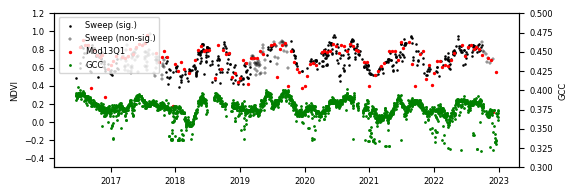

In [6]:

compare_fig = plot_gcc_comparison(cosmos_df["dt"], x_sweep, sig_vector, ndvi_comp["dt"], ndvi_comp['ndvi_c_filt'], cosmos_df["GCC"])
compare_fig.show()

C:\Users\Will.Rust\AppData\Local\Temp\ipykernel_13728\2138542072.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  sweep_loc_plot.show()


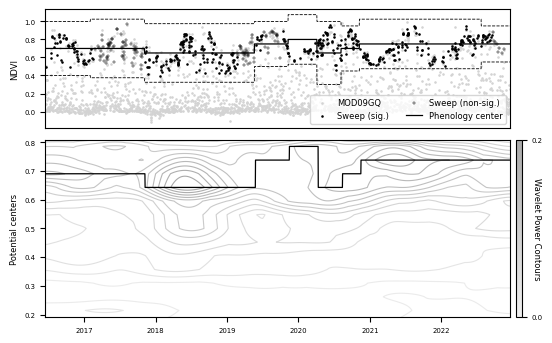

In [7]:
#PLOT SIGNAL LOCATION
sweep_loc_plot = plot_sweep_location(cosmos_df["dt"], x, x_sweep, sig_vector, signal_location_infil, signal_index_infil, center_mat_w)
sweep_loc_plot.show()


c:\Users\Will.Rust\OneDrive - Cranfield University\postdoc\Environment\Projects\RESTRECO\remote sensing WP\sweep_code\helper_functions.py:490: UserWarning: The following kwargs were not used by contour: 'aspect'
  ax[0, 1].contourf(np.abs(wx_og), aspect = 'auto', levels = levels, cmap = grey_cmap)
c:\Users\Will.Rust\OneDrive - Cranfield University\postdoc\Environment\Projects\RESTRECO\remote sensing WP\sweep_code\helper_functions.py:495: UserWarning: The following kwargs were not used by contour: 'aspect'
  contour = ax[1, 1].contourf(np.abs(wx_filt), aspect = 'auto', levels = levels, cmap = grey_cmap)
c:\Users\Will.Rust\OneDrive - Cranfield University\postdoc\Environment\Projects\RESTRECO\remote sensing WP\sweep_code\helper_functions.py:530: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1, 2].set_xticklabels([f'{tick:.1f}' for tick in ticks])
C:\Users\Will.Rust\AppData\Local\Temp\ipykernel_13728\118

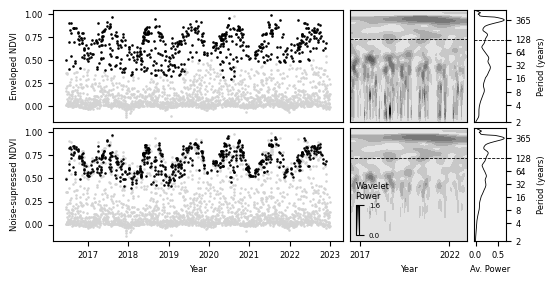

In [8]:
#PLOT SIGNAL DENOISING
sweep_extract_plot = plot_sweep_extract(cosmos_df["dt"], x, x_sweep, signal_location_infil, wx_og, wx_filt, l_period)
sweep_extract_plot.show()

In [9]:
#Run DLM with kalman filter for both SWEEP NDVI and Composite NDVI
sm_sweep, sC_sweep, snu_sweep, FF_sweep, *_ = run_dlm(x_sweep.values, anCLM, vid, 1, rseas, fs1_deltas)
sm_modcomp, sC_modcomp, snu_modcomp, FF_modcomp, *_ = run_dlm(ndvi_comp["ndvi_c_filt"].values.ravel(), anCLM_c, vid, 16, rseas, fs16_deltas)


C:\Users\Will.Rust\AppData\Local\Temp\ipykernel_13728\2827387203.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  dlm_plot.show()


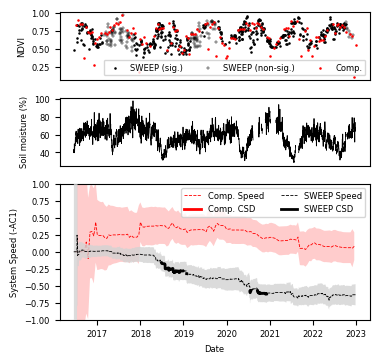

In [10]:
warmup = int(365.25 * 1.5)
dlm_plot = plot_dlm_results(cosmos_df["dt"], x_sweep, sig_vector, ndvi_comp["dt"], ndvi_comp['ndvi_c_filt'], cosmos_df["cosmos_vwc"], FF_sweep, FF_modcomp, quantile, warmup)
dlm_plot.show()


In [ ]:
#PLOT ATTRACTOR SURFACE FOR GLENWHERRY
plot_params  = pd.Series({
    "site_name": "Glenwherry",
    "x_lab_offset": "0.025, -0.025, 0.025, 0.025",
    "label_coord": "[-0.1, 0.05][-0.15, 0.31][0.025, 0.35][0, 0.6]",
    "warmup": 548
})

stability_landscape = plot_landscape(FF_sweep, int(plot_params[3]), cosmos_df['dt'], plot_params)
stability_landscape.show()

C:\Users\Will.Rust\AppData\Local\Temp\ipykernel_13728\2615652619.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stability_landscape = plot_landscape(FF_sweep, int(plot_params[3]), cosmos_df['dt'], plot_params)
c:\Users\Will.Rust\OneDrive - Cranfield University\postdoc\Environment\Projects\RESTRECO\remote sensing WP\sweep_code\sweep_landscape_functions.py:693: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

c:\Users\Will.Rust\OneDrive - Cranfield University\postdoc\Environment\Projects\RESTRECO\remote sensing WP\sweep_code\sweep_landscape_functions.py:696: FutureWarning:

Series.__getitem__ treating keys as positio